In [ ]:
#| default_exp models

In [ ]:
#| export
import fastai
from copy import deepcopy
from fastcore.all import *
from fastai.vision.all import *

from step.data import DEFAULT_TOKEN

# Utility layers

In [ ]:
#| export
def get_act(vocab_sz, yrange=(0, 2.05)):
    """Provides a sigmoid or softmax activation according to
    inferring the task (regression or classification) from `vocab_sz`."""
    if vocab_sz == 1:
        act = SigmoidRange(*yrange)
    else:
        act = nn.Softmax(dim=-1)
    return act

def _get_acts(n_class, yrange=(0, 2.05)):
    act = SigmoidRange(*yrange) if n_class == 1 else noop
    activation = nn.Softmax(dim=-1) if n_class > 1 else noop
    return act, activation
    
class Normalization(Module):
    "Z-Normalization over the designated dimension."
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): 
        return (x - x.mean(self.dim).unsqueeze(self.dim))/x.std(self.dim).unsqueeze(self.dim)
    
class Transpose(Module):
    "Transposition layer of dims."
    def __init__(self, dims): self.dims = dims
    def forward(self, x): return x.transpose(*self.dims)

class ConcatPooling(Module):
    "Perform max and average pool over `dim`. Outputs [avg_pool, max_pool]."
    def __init__(self, dim=-1): self.dim = dim
    def forward(self, x): return torch.cat([x.mean(dim=self.dim), x.max(dim=self.dim)[0]], dim=1)
    
def tfm_encoder(dim, n_head=1, n_layers=8, dim_ff=1024, dropout=0.1, activation='relu'):
    "Creates a `nn.TransformerEncoder`."
    encoder_layer = nn.TransformerEncoderLayer(dim, n_head, dim_ff, dropout, activation)
    encoder_norm = nn.LayerNorm(dim)
    return nn.TransformerEncoder(encoder_layer, n_layers, encoder_norm)

# Dense layers

In [ ]:
#| export
class Classifier(Module):
    "Dense classifier."
    def __init__(self, dims, ps, final_act=False, yrange=None, trp=(2, 1)):
        if len(ps) != len(dims)-1: 
            raise ValueError(f"""Number of layers {len(dims)} and dropout
                                 values {len(ps)} don't match.""")
        acts = [nn.ReLU(inplace=True)] * (len(dims) - 2) + [None]
        layers = [LinBnDropTrp(i, o, p=p, act=a, trp=trp)
                  for i,o,p,a in zip(dims[:-1], dims[1:], ps, acts)]
        if final_act: layers.append(get_act(dims[-1], yrange=yrange))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): return self.layers(x)
    
class LinBnDropTrp(nn.Sequential):
    "Linear layer with batch norm, dropout and transposition."
    def __init__(self, n_in, n_out, bn=True, p=0., trp=(2, 1), act=None, ndim=1):
        layers = [BatchNorm(n_in, ndim=ndim)] if bn else []
        if p!=0.: layers.append(nn.Dropout(p))
        if trp: layers = [Transpose(trp)] + layers + [Transpose(trp)]
        layers.append(nn.Linear(n_in, n_out, bias=not bn))
        if act is not None: layers.append(act)
        super().__init__(*layers)

We use the `Classifier` at the end of most of our models. It is comprised of `LinBnDropTrp` layers that allow us to obtain the desired output dimension for any task. Furthermore, we can specify whether to apply a final activation function through `final_act`. In classification tasks with pytorch, where we use `CrossEntropyLoss` or fastai's `CrossEntropyLossFlat`, we do not want to apply the softmax activation function to the logits before passing them to the loss function. 

# Self-attention-based models

Extracting pointwise properties of a sequence can be understood as a translation task. Thus, it is natural to tackle the problem using a transformer or other purely self-attention-based architectures. Here, we provide a full `Transformer` (encoder + decoder), and an encoder-only model `EncoderClassifier`.  

In [ ]:
#| export
class Transformer(nn.Module):
    "Transformer architecture."
    def __init__(self, dim, n_class=5, nhead_enc=1, nhead_dec=1, num_encoder_layers=6,
                 num_decoder_layers=6, dim_ff=2048, dropout=0.1, activation='relu'):
        super(Transformer, self).__init__()
        store_attr('dim,n_class')
        encoder_layer = nn.TransformerEncoderLayer(dim, nhead_enc, dim_ff, dropout, activation)
        encoder_norm = nn.LayerNorm(dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        self.linear_enc_dec = nn.Linear(dim, n_class)
        
        decoder_layer = nn.TransformerDecoderLayer(n_class, nhead_dec, dim_ff, dropout, activation)
        decoder_norm = nn.LayerNorm(n_class)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        self.memory_norm = deepcopy(decoder_norm)
        
        self.generator = nn.Linear(n_class, n_class)
        self.activation = nn.Softmax(dim=-1)
        
        self._reset_parameters()
        
    def forward(self, src, tgt, use_mask=True, src_mask=None, tgt_mask=None,
                memory_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None,
                memory_key_padding_mask=None):
        "`src` is the input to predict `tgt`."
        src, tgt = [x.transpose(1, 0) for x in (src, tgt)]
        if use_mask and tgt_mask is None: tgt_mask = self.get_square_subsequent_mask(tgt.shape[0])
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        memory = self.memory_norm(self.linear_enc_dec(memory)) # Our cheecky lil' trick
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        return self.generator(output).transpose(1, 0)
    
    def segment(self, x, n_class=5, y=None, length=None):
        "Segmentation of input `x` without target reference."
        x = self._check_rank(x)
        if length is None: bs, length, _ = x.shape
        else:              bs = x.shape[0]
        y = DEFAULT_TOKEN * torch.ones(bs, 1, self.n_class).type_as(x) if y is None else y
        outs, preds = [], []
        # Check preds shapes to stack them afterwards
        for _ in range(length):
            out = self.forward(x, y, use_mask=False)[:, -1].unsqueeze(1)
            prob = self.activation(out)
            pred = prob.argmax(-1)
            next_y = torch.zeros(bs, n_class, device=x.device
                                ).scatter_(-1, pred, 1).unsqueeze(1)
            y = torch.cat([y, next_y], dim=1)
            preds.append(pred); outs.append(out)
        return torch.cat(preds, dim=1), y[:, 1:], torch.cat(outs, dim=1)
        
    def get_square_subsequent_mask(self, sz):
        r"""Generate a square mask for the sequence. Masked positions are filled with
            float('-inf'). Unmasked positions are filled with float(0.0)."""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == False, float('-inf')).masked_fill(mask, float(0.))
        return mask.to(default_device())
    
    def _check_rank(self, x):
        "Checks that input rank is correct."
        rank = len(x.shape)
        if   rank == 1: return x.unsqueeze(0).unsqueeze(-1)
        elif rank == 2: return x.unsqueeze(0)
        elif rank == 3: return x
        else: raise ValueError(f"Input should be rank 1, 2 or 3 tensor. Got rank {rank}.")
         
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

The `Transformer` implements a basic transformer architecture as introduced in [Attention is all you need](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) from Vaswani, et. al., in 2017.

In [ ]:
#| hide
from step.data import get_transformer_dls, MODEL_PATH

Let's see an example of how to train a transformer to perform a segmentation task of the anomalous diffusion model in heterogeneous trajectories.

In [ ]:
# Data loaders
tfm_dls = get_transformer_dls(bs=128)
tfm_dls.device = default_device()
# Model
my_tf = Transformer(1, num_encoder_layers=4, num_decoder_layers=4, dim_ff=500)
my_tf.to(default_device())
# Learner
learn = Learner(tfm_dls, my_tf, loss_func=CrossEntropyLossFlat(), model_dir=MODEL_PATH)

In [ ]:
learn.fit_one_cycle(15, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.081026,0.063063,00:41
1,0.047181,0.045920,00:40
2,0.044656,0.043783,00:41
3,0.043903,0.043491,00:40
4,0.043756,0.043521,00:41
5,0.043616,0.043354,00:41
6,0.043514,0.043158,00:40
7,0.043429,0.043019,00:41
8,0.043339,0.043081,00:41
9,0.043207,0.042961,00:41


::: {.callout-warning}
The task is particularly bad conditioned for a naive transformer training such as this one. The loss does get low, but it is mainly because the model learns to predict whatever the previous token was, so be careful!
:::

In these segmentation tasks over piecewise constant segments, the target may look like $[2,2,2,2,2,1,1,1,1,1]$. With such naive training scheme, the transformer learns to replicate whatever the last digit is and it fails to find the changepoints. Let's have a look at some predictions.

In [ ]:
x, y_one_hot, y = dls.one_batch()
learn.model.eval()
preds, pred_one_hot, outs = learn.model.segment(x)

In [ ]:
preds[:10, :10]

tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')

In [ ]:
y[:10, :10]

tensor([[4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')

The model has correctly predicted the label for the first segment: `4` corresponding to SBM. However, it has then proceeded to replicate the label over the whole trajectory. You'll need some extra tricks to train this :)

In [ ]:
#| export
class PositionalEncoding(Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        r"Positional encoding of the form $sin(\omega_k t), cos(\omega_k t)$ with $\omega_k=\frac{1}{10000^{2k/d}} for even `d_model`."
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        omega = 1/(10000**(torch.arange(0, d_model, 2)/d_model)) # d_model must be even
        pos_enc = torch.zeros(max_len, 1, d_model)
        pos_enc[:, 0, 0::2] = torch.sin(omega*position)
        pos_enc[:, 0, 1::2] = torch.cos(omega*position)
#         self.pos_enc = pos_enc
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        "Adds positional encoding to input `x` with shape [length, batch_size, d_model]."
        x = x + self.pos_enc[:x.size(0)]
        return self.dropout(x)

Transformers see the trajectories all at once without any notion of distance between the points. Here, we implement a positional encoding based on the addition of sines and cosines to the data, as introduced in [the original paper](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In [ ]:
pe = PositionalEncoding(14, max_len=100)
pos_enc = pe.pos_enc.squeeze()

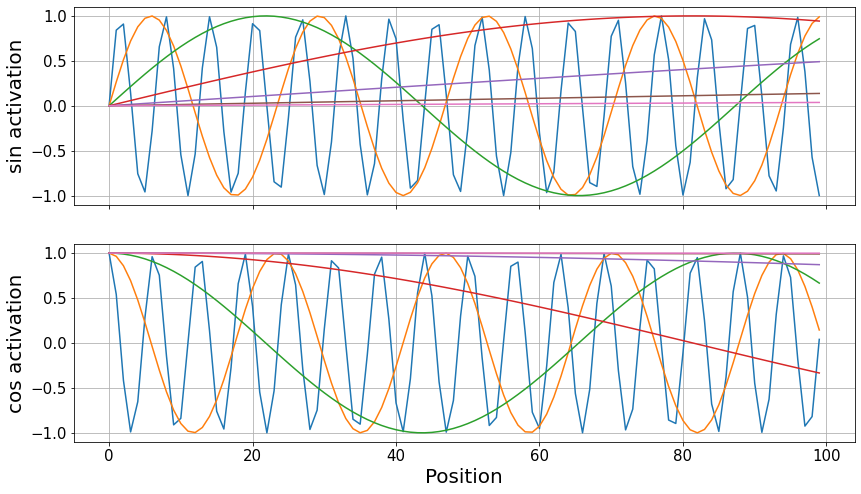

In [ ]:
#| code-fold: true
fontsize, ticksize = 20, 15
fig, axes = plt.subplots(2, sharex=True, figsize=(14, 8))
for sin, cos in zip(pos_enc.T[::2], pos_enc.T[1::2]):
    axes[0].plot(sin)
    axes[1].plot(cos)

axes[1].set_xlabel("Position", fontsize=fontsize)
axes[0].set_ylabel("sin activation", fontsize=fontsize)
axes[1].set_ylabel("cos activation", fontsize=fontsize)
for ax in axes:
    ax.grid()
    ax.tick_params(labelsize=ticksize)

In [ ]:
#| export
class EncoderClassifier(Module):
    "Transformer encoder with a linear classifier."
    @delegates(Classifier.__init__)
    def __init__(self, dim, length=200, n_class=5, nhead_enc=1, num_encoder_layers=6,
                 dim_ff=2048, dropout=0.1, activation='relu', linear_layers=[1024],
                 ps=None, yrange=(0, 2.05), **kwargs):
        super(EncoderClassifier, self).__init__()
        store_attr('dim,n_class')
        self.norm = Normalization(1)
        self.encoder = tfm_encoder(dim, nhead_enc, num_encoder_layers,
                                   dim_ff, dropout, activation)
#         self.concat_pool = ConcatPooling()
        lin_dim = [2*length] + linear_layers + [n_class]
        if ps is None: ps = [dropout]*(len(linear_layers)+1)
        self.linear = Classifier(lin_dim, ps, **kwargs)
        self.act, self.activation = _get_acts(n_class, yrange)
        
        self._reset_parameters()
        
    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        "to ease the integration with fastai."
        src = x.transpose(1, 0)
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
#         pool_out_enc = self.concat_pool(out_enc.transpose(1, 0))
        return self.act(self.linear(out_enc.transpose(1, 0)))
    
    def get_random_mask(self, sz, pct=0.15):
        "Returns random mask with `pct` probability of dropping every input."
        mask = torch.rand(sz, sz) >= pct
        mask = mask.float().masked_fill(mask == False, float('-inf')).masked_fill(mask, float(0.))
        return mask.to(default_device())
        
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [ ]:
#| hide
from step.data import get_segmentation_dls

In [ ]:
dls = get_segmentation_dls()
dls.device = default_device()
enc = EncoderClassifier(1, num_encoder_layers=12, dim_ff=1024)
enc.to(default_device())
learn = Learner(dls, enc, loss_func=CrossEntropyLossFlat(), model_dir=MODEL_PATH)

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-1)

epoch,train_loss,valid_loss,time
0,1.611631,1.609615,00:58
1,1.611847,1.613333,00:58
2,1.611033,1.609803,00:59
3,1.609777,1.609575,00:59
4,1.609749,1.609633,01:00


# Combined convolutional and self-attention models

Convolutional models have seen great success characterizing diffusion trajectories, specially combined with recurrent neural networks, as seen in the [AnDi challenge paper](https://www.nature.com/articles/s41467-021-26320-w). We provide a few models that combine convolutional feature extractors with self-attention mechanisms.

In [ ]:
#| export
class ConvAttn(Module):
    "Convolution layers with a transformer encoder."
    def __init__(self, dim, n_class=5, conv_dims=[64, 128, 128], nhead_enc=1, num_encoder_layers=6, 
                 dim_ff=2048, dropout=0.1, linear_layers=[128], activation='relu', yrange=(0, 2.05)):
        store_attr('dim,n_class')
        self.norm = Normalization(1)
        conv_dims = [dim] + conv_dims
        conv_layers = [ConvLayer(ni, nf, ndim=1) for ni, nf in zip(conv_dims[:-1],conv_dims[1:])]
        self.convs = nn.Sequential(*conv_layers)
        self.encoder = tfm_encoder(conv_dims[-1], nhead_enc, num_encoder_layers, dim_ff, dropout, activation)
        linear_layers = [conv_dims[-1]] + linear_layers + [n_class]
        ps = [dropout]*(len(linear_layers)-1)
        self.linear = Classifier(linear_layers, ps, trp=(2, 1))
        # act is called in forward, activation is called in validation functions.
        self.act, self.activation = _get_acts(n_class, yrange)
        
    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        x = self.norm(x)
        x = self.convs(x.transpose(2, 1)).transpose(2, 1)
        src = x.transpose(1, 0)
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return self.act(self.linear(out_enc.transpose(1, 0)))
    
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)  

`ConvAttn` is built out of basic convolutional layers that act as an embedding for a transformer encoder. There is a dense `Classifier` at the end that achieves the desired output dimensions. 

In [ ]:
#| hide
from step.data import get_segmentation_dls, MODEL_PATH

Performing a diffusion model segmentation task is the most straightforward, simply specify the trajectory dimension, which defaults to `dim=1` in the dataloaders and provide the appropiate loss function `CrossEntropyLossFlat`. 

In [ ]:
dls = get_segmentation_dls()
dls.device = default_device()
model = ConvAttn(2, conv_dims=[64, 128, 128], num_encoder_layers=8, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), model_dir=MODEL_PATH)

For anomalous exponent segmentation, we must specify the target `target='y_exp'` as well as provide the corresponding loss function, either `L1LossFlat` or `MSELossFlat`. Don't forget to provide the model with the proper number of classes `n_class=1`.

In [ ]:
dls = get_segmentation_dls(target='y_exp')
dls.device = default_device()
model = ConvAttn(1, n_class=1, conv_dims=[32, 64, 128, 256], num_encoder_layers=8, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

To train, we simply call `learn.fit_one_cycle`.

In [ ]:
#| export
class XResBlocks(nn.Sequential):
    "XResNet block."
    @delegates(ResBlock)
    def __init__(self, block, layers, expansion=1, p=0.0, c_in=1, n_out=1000, stem_szs=(32,32,64),
                 block_szs=None, widen=1.0, ndim=1, ks=3, stride=2, sa=False, stem_stride=False,
                 act_cls=defaults.activation, **kwargs):
        store_attr('block,expansion,act_cls,ndim,ks')
        if ks % 2 == 0: raise Exception(f'Kernel size has to be odd! Input ks={ks}.')
        stem_szs = [c_in, *stem_szs]
        stem = [ConvLayer(stem_szs[i], stem_szs[i+1], ks=ks, stride=stride if (i==0 and stem_stride) else 1,
                          act_cls=act_cls, ndim=ndim) for i in range(len(stem_szs)-1)]
        if len(stem) > 1: stem += [MaxPool(ks=ks, stride=stride, padding=ks//2, ndim=ndim)]
        n_layers = len(layers)
        block_szs = [128, 256, 512] + [256]*(n_layers-4) if block_szs is None else block_szs
        block_szs = [int(o*widen) for o in block_szs[:n_layers]]
        block_szs = [stem_szs[-1]//expansion] + block_szs
        blocks    = self._make_blocks(layers, block_szs, sa, stride, **kwargs)
        
        super().__init__(*stem, *blocks)
        init_cnn(self)
        
    def _make_blocks(self, layers, block_szs, sa, stride, **kwargs):
        return [self._make_layer(ni=block_szs[i], nf=block_szs[i+1], blocks=l,
                                 stride=1 if i==0 else stride, sa=sa and i==len(layers)-4, **kwargs)
                for i,l in enumerate(layers)]

    def _make_layer(self, ni, nf, blocks, stride, sa, **kwargs):
        return nn.Sequential(
            *[self.block(self.expansion, ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                      sa=sa and i==(blocks-1), act_cls=self.act_cls, ndim=self.ndim, ks=self.ks, **kwargs)
              for i in range(blocks)])

`XResBlocks` follow the [XResNet architecture](https://openaccess.thecvf.com/content_CVPR_2019/html/He_Bag_of_Tricks_for_Image_Classification_with_Convolutional_Neural_Networks_CVPR_2019_paper.html) to build a convolutional neural network feature extractor.

The blocks start with an initial purely-convolutional stem. Then, every subsequent block consists of two convolutional layers with a skip connection or identity path. The identity paths have a single convolutional layer with kernel size 1 to match the channel dimension of their corresponding convolutional paths. 

In [ ]:
#| export
@delegates(XResBlocks.__init__)
class XResAttn(Module):
    "Xresnet blocks with attention at the end."
    def __init__(self, dim, n_class=5, conv_blocks=[1, 1], block=ResBlock, block_szs=[64, 128],
                 nhead_enc=1, n_encoder_layers=6, dim_ff=2048, dropout=0.1, pos_enc=True, 
                 linear_layers=[128], activation='relu', norm=True, yrange=(0, 2.05), **kwargs):
        store_attr('dim,n_class')
        self.norm = Normalization(1) if norm else noop
        self.convs = XResBlocks(block, conv_blocks, c_in=dim, block_szs=block_szs, stride=1, **kwargs)
        self.encoder = tfm_encoder(block_szs[-1], nhead_enc, n_encoder_layers, dim_ff, dropout, activation)
        self.pos_enc = PositionalEncoding(block_szs[-1]) if pos_enc else noop
        linear_layers = [block_szs[-1]] + linear_layers + [n_class]
        ps = [dropout]*(len(linear_layers)-1)
        self.linear = Classifier(linear_layers, ps, trp=(2, 1))
        # act is called in forward, activation is called in validation functions.
        self.act, self.activation = _get_acts(n_class, yrange)
        
    def forward(self, x, use_mask=False, src_mask=None, src_key_padding_mask=None):
        x = self.norm(x)
        x = self.convs(x.transpose(2, 1)).transpose(2, 1)
        src = self.pos_enc(x.transpose(1, 0))
        if use_mask and src_mask is None: src_mask = self.get_random_mask(src.shape[0])
        out_enc = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return self.act(self.linear(out_enc.transpose(1, 0)))
    
    def _reset_parameters(self):
        "Initiate parameters in the transformer model."
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

`XResAttn` is an evolution of `ConvAttn` in which we replace the basic convolutional layer by `XResBlocks`.

In [ ]:
dim = 2
dls = get_segmentation_dls(dim=dim, target='y_exp', size=10000)
dls.device = default_device()
model = XResAttn(dim, n_class=1, stem_szs=(32,), conv_blocks=[1, 1], block_szs=[64, 128], 
                 n_encoder_layers=6, dim_ff=512, nhead_enc=8, linear_layers=[])
model.to(default_device())
learn = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

In [ ]:
learn.fit_one_cycle(15, lr_max=2e-4)

epoch,train_loss,valid_loss,time
0,0.351831,0.341731,05:52
1,0.317376,0.313373,05:53
2,0.296154,0.291456,05:53
3,0.276105,0.274482,05:53
4,0.265737,0.263980,05:53
5,0.256997,0.253854,05:53
6,0.245702,0.243755,05:53
7,0.243005,0.237430,05:53
8,0.235679,0.235492,05:53
9,0.231861,0.231436,05:53


## U-net

[U-nets](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28) were originally conceived to perform image segmentation. Therefore, they are particularly well-suited for the trajectory segmentation task.

We provide a dynamic U-net that takes the backbone of a model and transforms it into the U-like architecture.

In [ ]:
#| export
class GeneralPixleShuffle(Module):
    "Generalized Pixle Shuffle to work with any data dimensionality."
    def __init__(self, upscale_factor): self.scale = upscale_factor
    def forward(self, x):
        in_size = list(x.size())
        dim = len(in_size) - 2
        in_size[1] //= (self.scale**dim)
        out_size = [dim*self.scale for dim in in_size[2:]]
        in_view = x.contiguous().view(*in_size[:2], *(([self.scale]*dim) + in_size[2:]))
        idx = list(range(2, 2+2*dim))
        idx = idx[1::2] + idx[0::2]
        shuffle_out = (in_view.permute(0, 1, *(idx[::-1])).contiguous() if dim > 1 else
                       in_view.permute(0, 1, *idx).contiguous())                    
        return shuffle_out.view(*in_size[:2], *out_size)
        
def icnr_init_general(x, scale=2, init=nn.init.kaiming_normal_):
    "Generalized version of `icnr_init`."
    ni, nf, *shape = x.shape
    ni2 = int(ni/scale**len(shape))
    k = init(x.new_zeros([ni2, nf, *shape])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**len(shape))
    return k.contiguous().view([nf, ni, *shape]).transpose(0, 1)

In [ ]:
#| export
class PixelShuffleUpsampling(nn.Sequential):
    "Updample by `scale` from `ni` filters to `nf` using `GeneralPixleShuffle`."
    def __init__(self, ni, nf=None, scale=2, ndim=2, blur=False,
                 norm_type=NormType.Weight, act_cls=defaults.activation):
        super().__init__()
        nf = ifnone(nf, ni)
        layers = [ConvLayer(ni, nf*(scale**ndim), ks=1, ndim=ndim, norm_type=norm_type,
                            act_cls=act_cls, bias_std=0),
                  GeneralPixleShuffle(scale)]
        layers[0][0].weight.data.copy_(icnr_init_general(layers[0][0].weight.data))
        if blur:
            pad = getattr(nn, f"ReplicationPad{int(ndim)}d")
            avg_pool = getattr(nn, f"AvgPool{int(ndim)}d")
            layers += [pad((1, 0)*ndim), avg_pool(2, stride=1)]
        super().__init__(*layers)

In [ ]:
#| export
class UnetBlock(Module):
    "A quasi-UNet block using pixel shuffle upsampling."
    @delegates(ConvLayer.__init__)
    def __init__(self, up_in_c, x_in_c, hook, ndim=1, final_div=True, blur=False,
                 act_cls=defaults.activation, self_attention=False, init=nn.init.kaiming_normal_,
                 norm_type=None, **kwargs):
        self.dim = ndim
        self.hook = hook
        self.shuf = PixelShuffleUpsampling(up_in_c, up_in_c//2, ndim=ndim, blur=blur,
                                           act_cls=act_cls, norm_type=norm_type)
        self.bn = BatchNorm(x_in_c, ndim=ndim)
        ni = up_in_c//2 + x_in_c
        nf = ni if final_div else ni//2
        # Beware: using attention like this improved results in initial tests check whether it needs a transpose
#         self.attn = tfm_encoder(ni, n_head=1, n_layers=2, dim_ff=ni, dropout=0.1, activation='relu')
        self.conv1 = ConvLayer(ni, nf, ndim=ndim, act_cls=act_cls, norm_type=norm_type, **kwargs)
        self.conv2 = ConvLayer(nf, nf, ndim=ndim, act_cls=act_cls, norm_type=norm_type,
                               xtra=SelfAttention(nf) if self_attention else None, **kwargs)
        self.relu = act_cls()
        apply_init(nn.Sequential(self.conv1, self.conv2), init) # Add attention here accordingly

    def forward(self, up_in):
        s = self.hook.stored
        up_out = self.shuf(up_in)
        ssh = s.shape[-self.dim:]
        if ssh != up_out.shape[-self.dim:]:
            up_out = F.interpolate(up_out, s.shape[-self.dim:], mode='nearest')
        cat_x = self.relu(torch.cat([up_out, self.bn(s)], dim=1))
        return self.conv2(self.conv1(cat_x))

A key element of the U-net is the upsmapling branch. We do it by stacking `UnetBlock`s that perform convolution-based upsampling with pixel shuffle. We implement a `PixelShuffleUpsampling` layer that uses our `GeneralPixleShuffle`, which is a generalized version of the [original pixel shuffle](https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Shi_Real-Time_Single_Image_CVPR_2016_paper.html).

To build the downsampling branch, we take the desired architecture and we pass a dummy input through it to extract relevant information, such as the points at which dimensions change, which then need to be connected to the upsampling branch. 

In [ ]:
#| export
def get_sz_change_idxs(sizes):
    "Get the indexes of the layers where the size of the activation changes."
    feature_szs = [size[-1] for size in sizes]
    sz_chg_idxs = list(np.where(np.array(feature_szs[:-1]) != np.array(feature_szs[1:]))[0])
    return sz_chg_idxs

def model_sizes(m, size=(64,64)):
    "Pass a dummy input through the model `m` to get the various sizes of activations."
    with hook_outputs(m) as hooks:
        _ = dummy_eval(m, size=size)
        return [o.stored.shape for o in hooks]

def in_channels(m):
    "Return the shape of the first weight layer in `m `."
    for l in flatten_model(m):
        if getattr(l, 'weight', None) is not None and l.weight.ndim>=3: #conv1d or 2d
            return l.weight.shape[1]
    raise Exception('No weight layer')
    
def dummy_eval(m, size=(64,64)):
    "Evaluate `m` on a dummy input of a certain `size`"
    ch_in = in_channels(m)
    x = one_param(m).new(1, ch_in, *size).requires_grad_(False).uniform_(-1.,1.)
    with torch.no_grad(): return m.eval()(x)

In [ ]:
#| export
class ResizeToOrig(Module):
    "Merge a shortcut with the module result by adding or concatenating them if `dense=True`."
    def __init__(self, mode='nearest'): self.mode = mode
    def forward(self, x):
        dim = len(x.shape) - 2
        if x.orig.shape[-dim:] != x.shape[-dim:]:
            x = F.interpolate(x, x.orig.shape[-dim:], mode=self.mode)
        return x

In [ ]:
#| export

class AttnDynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_out, img_size, ndim=1, num_encoder_layers=6, nhead_enc=8, 
                 dim_ff=1024, p=0.1, act='relu', blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type,
                                              ndim=ndim, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type,
                                              ndim=ndim, **kwargs)).eval()
        x = middle_conv(x)

        tfm_enc = tfm_encoder(ni, nhead_enc, num_encoder_layers, dim_ff, p, act)
        transp = Transpose((2, 1))
        x = transp(tfm_enc(transp(x)))
        
        layers = [encoder, BatchNorm(ni, ndim=ndim), nn.ReLU(),
                  middle_conv, transp, tfm_enc, transp]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], ndim=ndim, final_div=not_final,
                                   blur=do_blur, self_attention=sa, act_cls=act_cls, init=init,
                                   norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-ndim:]:
            layers.append(PixelShuffleUpsampling(ni, ndim=ndim, act_cls=act_cls,
                                                 norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls,
                                   norm_type=norm_type, ndim=ndim, **kwargs))
        layers += [ConvLayer(ni, n_out, ks=1, act_cls=None, norm_type=norm_type,
                             ndim=ndim, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

`AttnDynamicUnet` builds a U-net like architecture from a given architecture (`encoder`). The input encoder conforms the downsampling branch, then, we add a convolution and a transformer encoder at the center (bottom of the U), and build the upsampling branch with `UnetBlock`s that have skip connections wherever the dimension in the encoder changes.

In [ ]:
#| export
class UnetModel(SequentialEx):
    "U-net with a final dense layer."
    @delegates(AttnDynamicUnet.__init__)
    def __init__(self, encoder, n_class, img_size, nf=64, linear_layers=[128], p=0.1, y_range=(0, 2.05), **kwargs): 
        norm = Normalization(1)
        unet = AttnDynamicUnet(encoder, nf, img_size, p=p, **kwargs)
        tp = Transpose((2, 1))
        linear_layers = [nf] + linear_layers + [n_class]
        ps = [p]*(len(linear_layers)-1)
        linear = Classifier(linear_layers, ps, trp=(2, 1))
        act, self.activation =  _get_acts(n_class, yrange=y_range)
        
        layers = [norm, tp, unet, tp, linear, act]
        super().__init__(*layers)

`UnetModel` uses `AttnDynamicUnet` to build a U-net from a desired architecture and appends a `Classifier` at the end to obtain the desired output dimension for the task.

For example, we can easily build a U-net with an XResNet encoder to infer the anomalous diffusion exponent $\alpha$ at every time step of the input trajectories.

In [ ]:
#| hide
from step.data import get_segmentation_dls

In [ ]:
dls = get_segmentation_dls(target='y_exp')
dls.device = default_device()
encoder = XResBlocks(ResBlock, [1, 2, 1], c_in=1, stem_szs=(32,), block_szs=[64, 128, 256])
umodel = UnetModel(encoder, 1, (200,), num_encoder_layers=4, dim_ff=512, linear_layers=[], y_range=(0, 2.05))
umodel.to(default_device())
ulearn = Learner(dls, umodel, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

In [ ]:
ulearn.fit_one_cycle(15, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,0.353012,0.344957,00:35
1,0.335089,0.334739,00:35
2,0.332037,0.327504,00:35
3,0.324102,0.323693,00:36
4,0.317840,0.316003,00:36
5,0.312131,0.314038,00:36
6,0.309137,0.310193,00:35
7,0.308097,0.305047,00:35
8,0.303723,0.304123,00:36
9,0.299942,0.302303,00:36
